# 03. 인물모드 문제점 찾기

## 1. 라이브러리 import

In [4]:
import numpy as np
import os
from matplotlib import pyplot as plt
from pixellib.semantic import semantic_segmentation

In [5]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


- importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
- 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
- importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
- 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인했다.

## 2.1 인물모드 직접 해 보기

- 분리모델 로딩

In [6]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_segmentation = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model_segmentation.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

#pascalvoc 데이터의 라벨종류
LABEL_NAMES = np.array([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
colormap[:, [0, 2]] = colormap[:, [2, 0]]#1열 3열 바꾸기 RGB->BGR

- 이미지 배경을 흐리게 만드는 함수

In [7]:
#category는 LABEL_NAMES에 있는것만
def ShallowFocus(img_path,category) :
    segvalues, output = model_segmentation.segmentAsPascalvoc(img_path)#이미지 세그멘트
    indices = np.where(LABEL_NAMES == category)[0]#원하는 카테고리 인덱스
    if(indices<0) :
        print('잘못된 category입니다')
        print(LABEL_NAMES)
        return
    if indices not in segvalues['class_ids'] :
        print(category+'는 찾지 못했습니다.')
        return
    seg_map = np.all(output==colormap[indices], axis=-1)#해당카테고리 칼러맵을 이용하여 분리 맵 만들기
    img_orig = cv2.imread(img_path)#원본이미지
    img_bg_blur,img_mask_color = blurAndMask(seg_map,img_orig)#blur된 백그라운드 및 이미지마스크 3채널변환 
    stickObject(img_orig, img_bg_blur,img_mask_color)#오브젝트 합성
    plt.imshow(seg_map, cmap='gray')
    plt.show()

In [8]:
def blurAndMask(seg_map,img_orig) :
    img_mask = seg_map.astype(np.uint8) * 255
    
    img_orig_blur = cv2.blur(img_orig, (13,13))# (13,13)은 blurring kernel size를 뜻합니다
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.show()
    return img_bg_blur,img_mask_color

In [9]:
def stickObject(img_orig, img_bg_blur, img_mask_color) :
    # np.where(조건, 참일때, 거짓일때)
    # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
    # 아닌 영역은 블러된 이미지 값을 사용합니다.
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    # plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original')
    axes[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    axes[1].set_title('ShallowFocus')

    plt.show()

- 새로운 이미지들에 적용해본다.

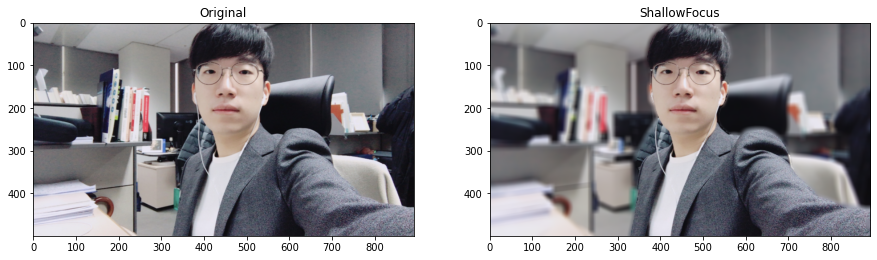

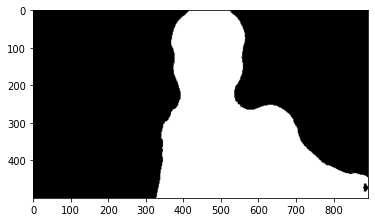

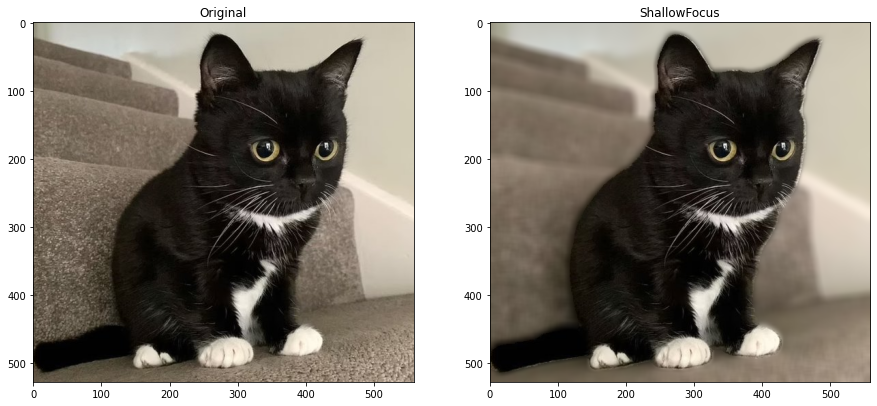

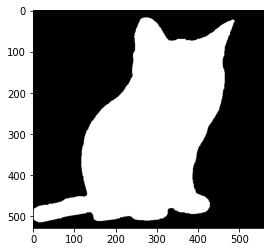

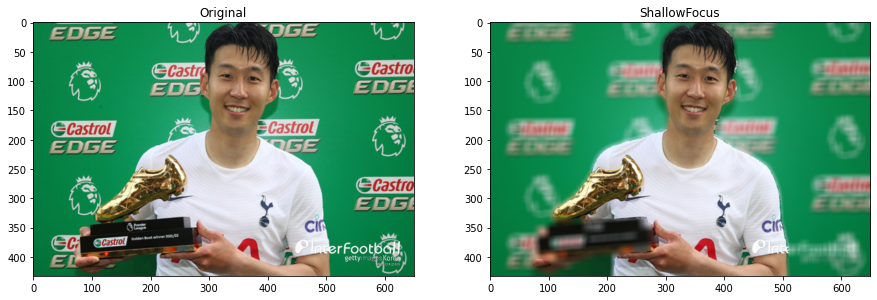

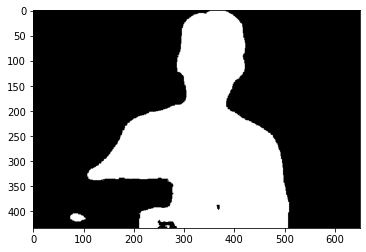

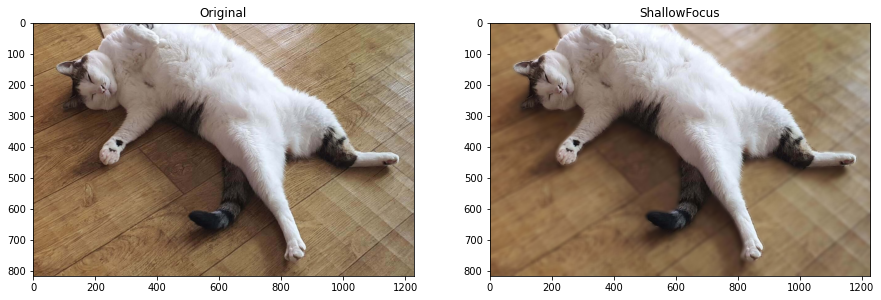

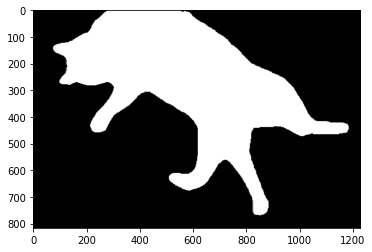

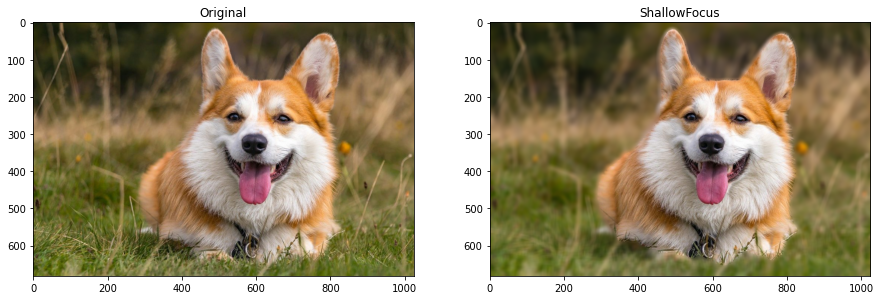

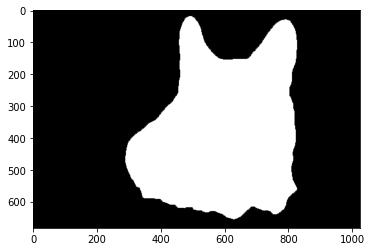

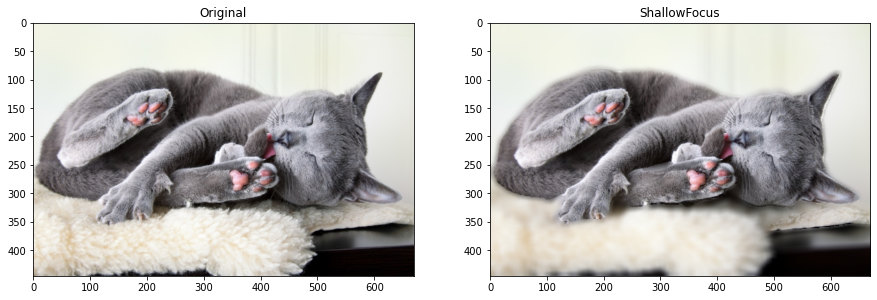

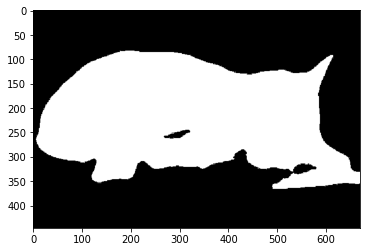

In [10]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
ShallowFocus(img_path,'person')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/488f9638-800c-4bac-ad65-82877fbff79b.jpg'   
ShallowFocus(img_path,'cat')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/602929_542564_1246.jpg'  
ShallowFocus(img_path,'person')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/b5773363bb83478555eb74e37e4ceeb7_res.jpg'  
ShallowFocus(img_path,'cat')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/corgi-g1a1774f95_1280-1024x682.jpg'  
ShallowFocus(img_path,'dog')
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/restmb_idxmake.jpg'  
ShallowFocus(img_path,'cat')

- 사람이 아닌 고양이와 개의 경우에도 아웃포커싱 사진을 만들 수 있었다.
- 다만 배경의 재질이 고양이가 비슷한 마지막 사진의 경우 세그멘테이션이 어색하게 된 것을 볼 수 있다. 

- 다른 배경으로 크로마키처리를 해본다.

In [11]:
def ChromaKey(img_path, img_bg_path,category) :
    segvalues, output = model_segmentation.segmentAsPascalvoc(img_path)#이미지 세그멘트
    indices = np.where(LABEL_NAMES == category)[0]#원하는 카테고리 인덱스
    if(indices<0) :
        print('잘못된 category입니다')
        print(LABEL_NAMES)
        return
    if indices not in segvalues['class_ids'] :
        print(category+'는 찾지 못했습니다.')
        return
    seg_map = np.all(output==colormap[indices], axis=-1)#해당카테고리 칼러맵을 이용하여 분리 맵 만들기
    img_orig = cv2.imread(img_path)#원본이미지
    img_bg = cv2.imread(img_bg_path)#배경이미지
    img_bg = cv2.resize(img_bg, (img_orig.shape[1],img_orig.shape[0]))
    img_mask = seg_map.astype(np.uint8) * 255
    kernel = np.ones((5, 5), np.uint8)
    img_mask = cv2.dilate(img_mask, kernel, iterations=3)
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    stickObject(img_orig, img_bg,img_mask_color)#오브젝트 합성

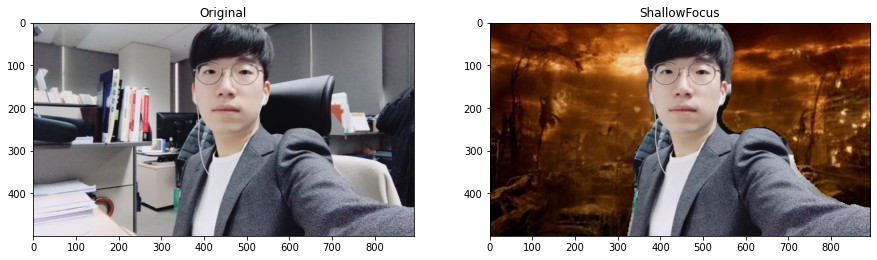

In [12]:
ChromaKey(os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png', os.getenv('HOME')+'/aiffel/human_segmentation/images/M0050002_CONSTANTINE_DISC_1-3[W578-].jpg','person')


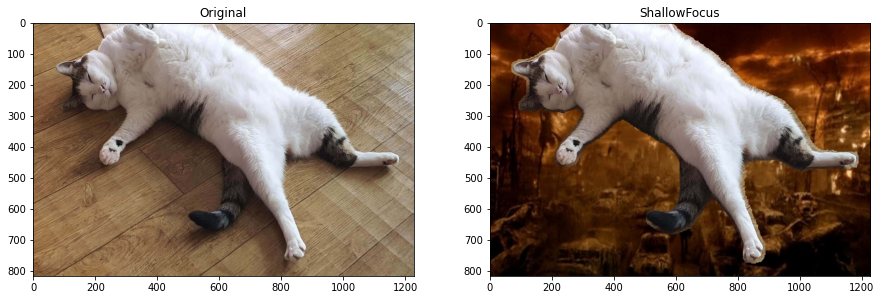

In [13]:
ChromaKey(os.getenv('HOME')+'/aiffel/human_segmentation/images/b5773363bb83478555eb74e37e4ceeb7_res.jpg', os.getenv('HOME')+'/aiffel/human_segmentation/images/M0050002_CONSTANTINE_DISC_1-3[W578-].jpg','cat')


- 블러처리 배경 외에도 다른 이미지 배경 또한 적용할 수 있다.

## 2.2 사진에서 문제점 찾기

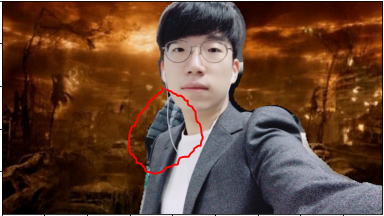

- 인물이 아닌 뒤에 있던 옷이 함께 세그멘테이션 된 것을 볼 수 있다.
- 인물의 옷과 비슷한 회색 계열이기 때문에 함께 인물 영역에 포함된 것으로 보인다.

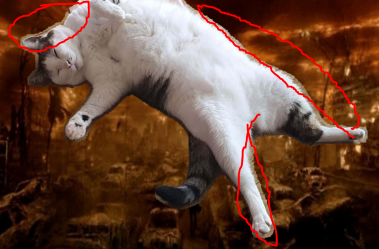

- 깔끔하게 잘 분리된 것으로 보이나, 뒷 배경인 장판이 조금씩 함께 분리되어 나온 것을 확인할 수 있다.
- 경계가 축소 될 필요성이 있다.

## 2.3 해결 방법을 제안해 보기

- Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인이다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별한다. 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘들다는 한계점을 가지고 있다.

- 이미지 처리에 사용되는 모폴로지 연산 중 Opening을 적용해본다.
    - 노이즈를 제거하고 객체를 분리한다.
    - 작은 객체나 노이즈를 제거하면서 큰 객체는 보존하려고 할 때 유용하다.
    - 또한 서로 가까이 붙어있는 객체들을 분리하는 데에도 효과적이다.
    - Erode 연산을 통해 노이즈를 제거하고 객체를 축소한다음, Dilate 연산을 통해 객체의 경계부분을 확장하여 객체를 확대시킨다.
    - 이를 통해 Erode 연산에서 제거된 큰 객체의 주요 부분은 Dilate 연산에서 원래의 크기로 복구되지만, 작은 노이즈나 작은 객체는 완전히 제거된 상태로 남게 된다.

In [14]:
def apply_opening(seg_map, kernel_size):
    '''
    오프닝 모폴로지 연산을 수행하는 함수
    - seg_map: 입력 세그멘테이션 맵
    - kernel_size: 모폴로지 연산에 사용할 커널의 크기
    '''
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(seg_map.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    return opening

In [27]:
def ShallowFocus2(img_path, category):
    segvalues, output = model_segmentation.segmentAsPascalvoc(img_path)
    indices = np.where(LABEL_NAMES == category)[0]
    
    seg_map = None  # 초기값 설정

    if indices.size == 0:  # 잘못된 카테고리 이름 검사
        print('잘못된 category입니다')
        print(LABEL_NAMES)
        return
    if indices[0] not in segvalues['class_ids']:  # 카테고리가 이미지 내에 존재하는지 검사
        print(category+'는 찾지 못했습니다.')
        return

    seg_map = np.all(output == colormap[indices], axis=-1)

    seg_map = apply_opening(seg_map, kernel_size=5) # 오프닝 연산 적용
    plt.imshow(seg_map, cmap='gray') # 오프닝 연산 결과 시각화
    plt.title("Opening Operation Result")
    plt.show()
    img_orig = cv2.imread(img_path)#원본이미지
    img_bg_blur,img_mask_color = blurAndMask(seg_map,img_orig)#blur된 백그라운드 및 이미지마스크 3채널변환 
    stickObject(img_orig, img_bg_blur,img_mask_color)#오브젝트 합성
    plt.show()

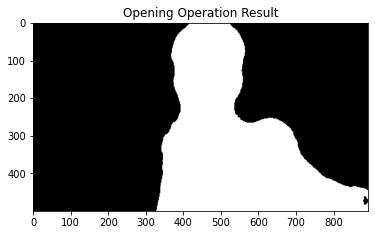

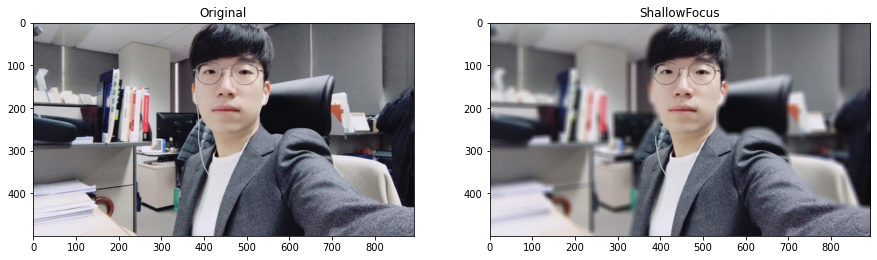

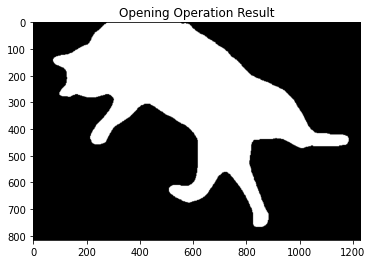

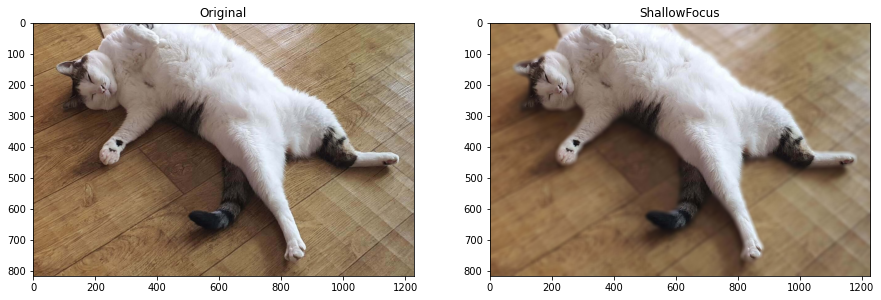

In [36]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
ShallowFocus2(img_path,'person')

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/b5773363bb83478555eb74e37e4ceeb7_res.jpg'  
ShallowFocus2(img_path,'cat')

- 배경에 명확한 대비를 주어서 비교해본다.
- Opening 연산이 적용된 ChromaKey2함수

In [23]:
def apply_opening(seg_map, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(seg_map.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    return opening

In [24]:
def ChromaKey2(img_path, img_bg_path, category):
    segvalues, output = model_segmentation.segmentAsPascalvoc(img_path)
    indices = np.where(LABEL_NAMES == category)[0]
    
    if indices.size == 0:
        print('잘못된 category입니다')
        print(LABEL_NAMES)
        return
    if indices[0] not in segvalues['class_ids']:
        print(category + '는 찾지 못했습니다.')
        return
    
    seg_map = np.all(output == colormap[indices], axis=-1)
    
    # 여기에서 seg_map에 오프닝 연산 적용
    seg_map = apply_opening(seg_map, kernel_size=5)
    
    img_orig = cv2.imread(img_path)
    img_bg = cv2.imread(img_bg_path)
    img_bg = cv2.resize(img_bg, (img_orig.shape[1], img_orig.shape[0]))
    img_mask = seg_map.astype(np.uint8) * 255
    kernel = np.ones((5, 5), np.uint8)
    img_mask = cv2.dilate(img_mask, kernel, iterations=3)
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    stickObject(img_orig, img_bg, img_mask_color)

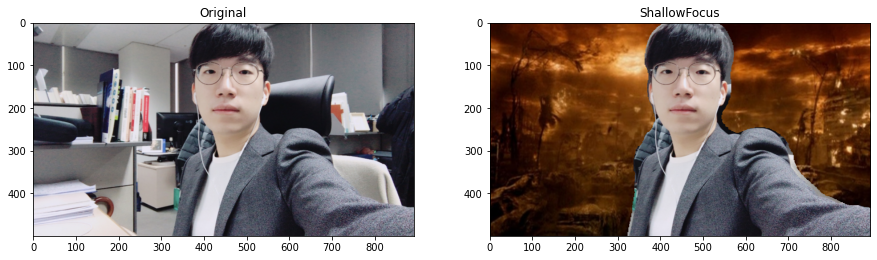

In [25]:
ChromaKey2(os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png', os.getenv('HOME')+'/aiffel/human_segmentation/images/M0050002_CONSTANTINE_DISC_1-3[W578-].jpg','person')

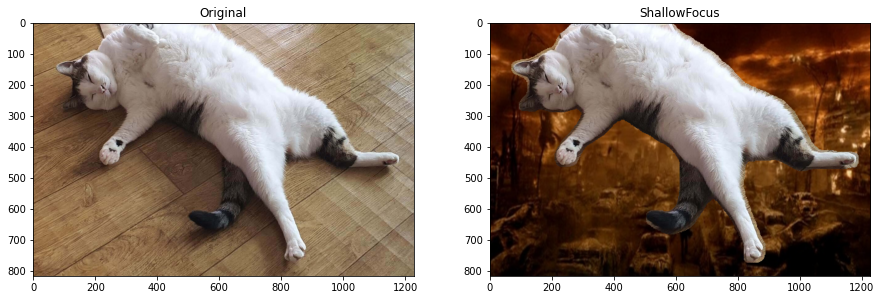

In [26]:
ChromaKey2(os.getenv('HOME')+'/aiffel/human_segmentation/images/b5773363bb83478555eb74e37e4ceeb7_res.jpg', os.getenv('HOME')+'/aiffel/human_segmentation/images/M0050002_CONSTANTINE_DISC_1-3[W578-].jpg','cat')

- 오프닝 연산을 적용하였으나 차이점을 크게 파악할 수 없었다.

- Opening 연산에서 'Dilate 연산을 통해 객체의 경계부분을 확장하여 객체를 확대시킨다.'는 점을 생각하여 Dilate 연산을 제외하고 erode 연산만을 적용하여 차이를 살펴본다.

- Erode 연산을 통해 경계를 축소하고 노이즈를 제거해본다.
- Erode 연산을 적용한 blurAndMask 함수

In [29]:
def blurAndMask(seg_map,img_orig) :
    img_mask = seg_map.astype(np.uint8) * 255
    # erode 연산 적용
    kernel = np.ones((15, 15), np.uint8)
    img_mask = cv2.erode(img_mask, kernel, iterations=1)

    img_orig_blur = cv2.blur(img_orig, (13,13))# (13,13)은 blurring kernel size를 뜻합니다
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
#     plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
#     plt.show()
    return img_bg_blur,img_mask_color

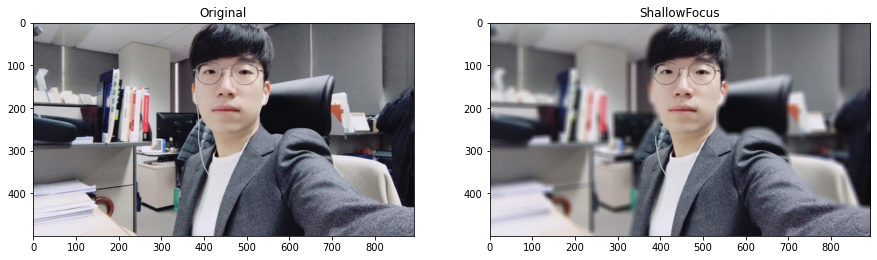

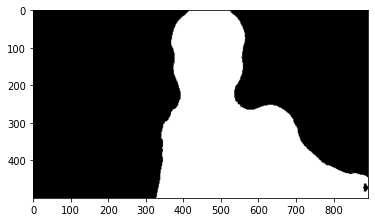

In [30]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
ShallowFocus(img_path,'person')

- 블러 적용 사진으로 정확한 문제점 파악이 어렵다.
    - 크로마키 적용 후 비교를 해본다.
- Erode 연산을 적용한 ChromaKey3 함수

In [33]:
def ChromaKey3(img_path, img_bg_path, category):
    segvalues, output = model_segmentation.segmentAsPascalvoc(img_path)
    indices = np.where(LABEL_NAMES == category)[0]
    
    if indices.size == 0:
        print('잘못된 category입니다')
        print(LABEL_NAMES)
        return
    if indices[0] not in segvalues['class_ids']:
        print(category + '는 찾지 못했습니다.')
        return
    
    seg_map = np.all(output == colormap[indices], axis=-1)
    
    img_orig = cv2.imread(img_path)
    img_bg = cv2.imread(img_bg_path)
    img_bg = cv2.resize(img_bg, (img_orig.shape[1], img_orig.shape[0]))
    
    # blurAndMask 함수 호출
    img_bg_blur, img_mask_color = blurAndMask(seg_map, img_orig)
    
    # 크로마키 합성
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

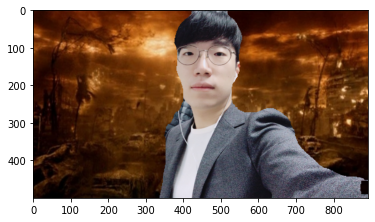

In [34]:
ChromaKey3(os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png', os.getenv('HOME')+'/aiffel/human_segmentation/images/M0050002_CONSTANTINE_DISC_1-3[W578-].jpg','person')

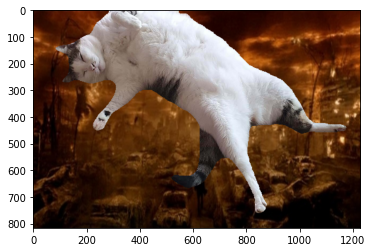

In [35]:
ChromaKey3(os.getenv('HOME')+'/aiffel/human_segmentation/images/b5773363bb83478555eb74e37e4ceeb7_res.jpg', os.getenv('HOME')+'/aiffel/human_segmentation/images/M0050002_CONSTANTINE_DISC_1-3[W578-].jpg','cat')

- 경계가 포함되어있던 문제를 가지고 있던 고양이 사진의 경우 경계가 축소되어 확연히 깔끔한 세그멘테이션 결과를 낸 것을 볼 수 있다.
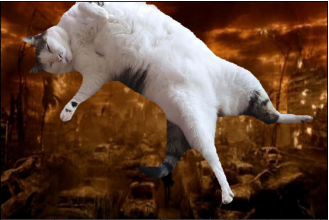 <br>

- Erode연산 적용 <br> 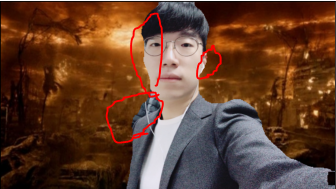
- Opening연산 적용 <br> 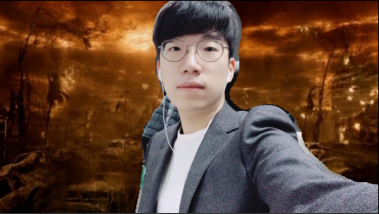

- 그러나 인물사진의 경우 opening 연산을 적용했을때, 기본 세그멘테이션만 적용했을 때 있었던 인물 이외의 객체가 적용 전보다 제외는 되었지만 남아있는 것을 확인할 수 있다.
- Erode연산을 적용하였을 때 경계가 더욱 줄어들었지만 왼쪽 귀가 삭제되었고, 경계가 줄어들며 얼굴부분이 함께 삭제된 문제점을 파악할 수 있었다.
- 원본 사진을 보고 문제점을 분석해본다.

- 고양이 사진의 배경의 경우 패턴이 비교적 일정한 장판이다.
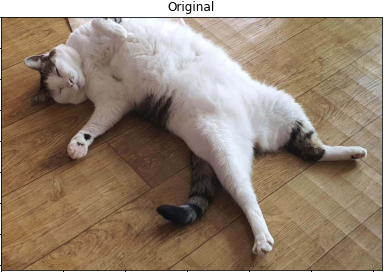<br>
- 인물 사진의 배경은 일정한 패턴을 가지고 있지는 않고 여러 물건들이 많다.
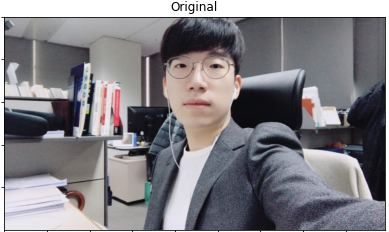<br>

- 고양이 사진의 경우 배경이 장판 이외에 다른 객체가 존재하지 않기 때문에 깔끔한 결과를 낼 수 있었다고 생각한다.
- 그에 반에 인물사진의 경우 외투, 의자, 줄이어폰 등 다른 객체가 존재하고 있고 이를 세그멘테이션하는 과정에서 어려움을 겪었을 것이라고 생각된다. 

## 3. 회고 및 참고자료
- 세그멘테이션의 부정확성을 해소하기 위하여 모폴로지 연산을 적용해볼 수 있다는 사실을 알게 되었다.
- 프로젝트에서 적용해본 모폴로지 연산 중 opening, erode 외에도 다양한 모폴로지 연산이 존재한다.
    - 객체의 경계를 확장하는 Dilate, 내부에 구멍이 생겼을 때 적용해볼 수 있는 closing, 객체의 경계를 더욱 강조하는 Morphological Gradient, 원본이미지와  Opening 또는 Closing의 차이를 통해 밝은 또는 어두운 지역의 노이즈나 작은 객체를 강조하는 Top Hat & Black Hat 등이 있으나 해당 사진들에서는 위의 문제들이 발생하지 않았기 때문에 적용해 보지 않았으나 다른 경우에 적용해볼 수 있는 기법이라 생각된다.
- 경계를 줄여서 더 정확한 세그멘테이션을 할 수 있지만 경계를 줄이는 작업은 삭제되어서는 안되는 부분을 삭제할 수 있다.
    - opening 연산의 경우 그 문제를 해결하기 위하여 Erode 연산 후 Dilate 연산을 수행하는 것으로 보인다.
    - 하지만 확장시키는 과정에서 경계가 삭제되어 있지 않아 문제가 제대로 해결되지 않는 문제점을 파악할 수 있었고 경계를 축소하고 노이즈를 제거하는 작업과 객체의 경계를 확장하는 작업이 각 이미지에 맞게 적절히 정교하게 적용될 수 있도록 하는 작업이 필요할 것이라 생각된다.

### 참고자료
- Chat GPT : 세그멘테이션의 부정확성을 해결하기 위해서 사용할 수 있는 연산 검색